# Deep Convolutional Generative Adversarial Network

This notebook is adapted from the notebook provided by Tensorflow available [here](https://www.tensorflow.org/tutorials/generative/dcgan).

This notebook access a zip folder of images stored on my Google Drive, but the framework provide should be easy to adapt to other problems/frameworks.

## Imports

In [0]:
!pip install -q imageio

In [0]:
import glob
import imageio
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display


## Mount Drive and Unzip Folders

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


- Only looking at images from Seattle, but feel free to uncomment the rest

In [0]:
# create directories for image extraction
!mkdir /content/img
!mkdir /content/generated_imgs
# !mkdir /content/img/Boston
# !mkdir /content/img/Charleston
# !mkdir /content/img/Chicago
# !mkdir /content/img/Denver
# !mkdir /content/img/Houston
# !mkdir /content/img/LosAngeles
# !mkdir /content/img/Miami
# !mkdir /content/img/Morgantown
# !mkdir /content/img/Portland
!mkdir /content/img/Seattle

In [0]:
# unzip images into respective folders
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/Boston.zip -d /content/img/Boston >/dev/null
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/Charleston.zip -d /content/img/Charleston >/dev/null
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/Chicago.zip -d /content/img/Chicago >/dev/null
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/Denver.zip -d /content/img/Denver >/dev/null
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/Houston.zip -d /content/img/Houston >/dev/null
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/LosAngeles.zip -d /content/img/LosAngeles >/dev/null
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/Miami.zip -d /content/img/Miami >/dev/null
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/Morgantown.zip -d /content/img/Morgantown >/dev/null
# !unzip /content/drive/My\ Drive/ubc-capstone-2020/Portland.zip -d /content/img/Portland >/dev/null
!unzip /content/drive/My\ Drive/ubc-capstone-2020/Seattle.zip -d /content/img/Seattle >/dev/null

## Explore the data

Directory: Seattle, Files found: 21659
Total files: 21659
Test image of Seattle
Image shape: (224, 224, 3)


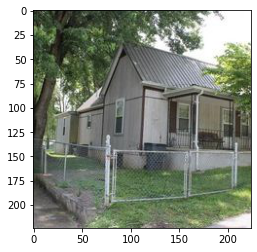

In [6]:
data_dir = '/content/img'
dnames = os.listdir(data_dir)
files = 0
for d in dnames:
  _ = len(os.listdir(data_dir + "/" + d))
  print(f"Directory: {d}, Files found: {_}")
  files += _
print(f"Total files: {files}")
print("=====================")
print(f"Test image of {d}")
test_img = imread(data_dir  + "/" + d + "/" + os.listdir(data_dir + "/" + d)[0])
print(f"Image shape: {test_img.shape}")
plt.imshow(test_img);

Now remove any images of only 1 colour channel and images that are not square

In [7]:
dim_dict = {}
channel_count = 0
size_count = 0
for d in dnames:
  dim1 = []
  dim2 = []
  print(f'Scanning directory: {d}')
  fnames = os.listdir(data_dir + "/" + d)
  for f in fnames:
    url = data_dir  + "/" + d + "/" + f
    im = imread(url)
    if len(im.shape) == 2:
      # print(f" - Removing {url}")
      channel_count += 1
      os.remove(url)
    if im.shape[0] != im.shape[1]:
      size_count += 1
      os.remove(url)
    dim1.append(im.shape[0])
    dim2.append(im.shape[1])
  dim_dict[d + '_d1'] = dim1
  dim_dict[d + '_d2'] = dim2
  print(f"  Single channel files removed : {channel_count}")
  print(f"      Non-square files removed : {size_count}")

Scanning directory: Seattle
Single channel files removed : 7
    Non-square files removed : 90


Check image dimensions

In [8]:
dim_df = pd.DataFrame()
for k in dim_dict.keys():
  dim_df[k[:5]] = pd.Series([np.mean(dim_dict[k]), np.min(dim_dict[k]), np.max(dim_dict[k])])
dim_df.index = ['mean', 'min', 'max']
dim_df

,Seatt
mean,223.972667
min,96.000000
max,310.000000


# Clustering goes here!

One thing that will drastically improve the image generation is if you can cluster them into more uniform groups...

# Prepare the data

In [0]:
BATCH_SIZE = 32
IMG_SIZE = 160

Found 17250 images belonging to 1 classes.


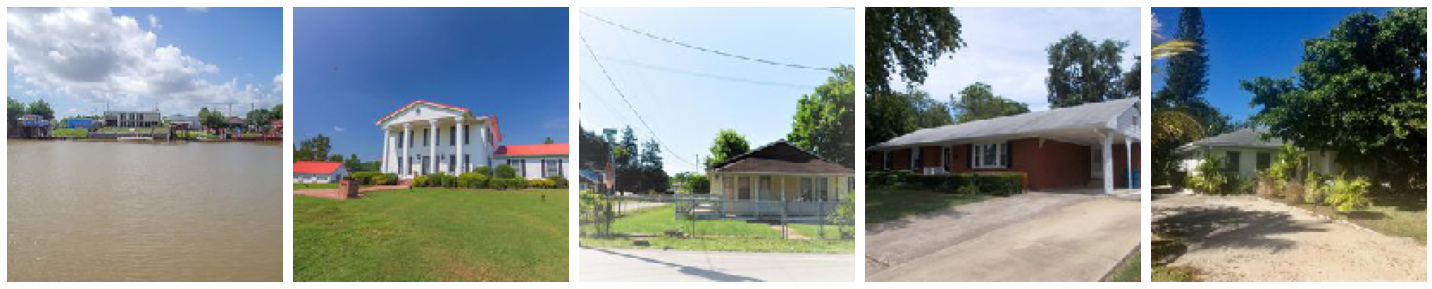

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  validation_split=0.2)
image_generator = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory=data_dir,
                                                      color_mode='rgb',
                                                      shuffle=True,
                                                      target_size=(IMG_SIZE, IMG_SIZE),
                                                      subset='training')

# view a sample
sample_images, _ = next(image_generator)
fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(sample_images[:5], axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Build the GAN

## The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [0]:
def make_generator_model(IMG_SIZE):
    
    if IMG_SIZE % 4 != 0:
      print("Error! Please use an IMG_SIZE divisible by 4.")
      return

    model = tf.keras.Sequential()
    model.add(layers.Dense(IMG_SIZE // 4 * IMG_SIZE // 4 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((IMG_SIZE // 4, IMG_SIZE // 4, 256)))
    assert model.output_shape == (None, IMG_SIZE // 4, IMG_SIZE // 4, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE // 4, IMG_SIZE // 4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE // 2, IMG_SIZE // 2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 3)

    return model

Use the (as yet untrained) generator to create an image.

In [0]:
generator = make_generator_model(IMG_SIZE)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :]);

## The Discriminator

The discriminator is a CNN-based image classifier.

In [0]:
def make_discriminator_model(IMG_SIZE):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [0]:
discriminator = make_discriminator_model(IMG_SIZE)
decision = discriminator(generated_image)
print(f"Output = {np.squeeze(decision.numpy()):.5f}")
print(" Class = Real") if np.squeeze(decision.numpy()) > 0 else print(" Class = Fake")

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [0]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs=5):
  for epoch in range(epochs):
    print(f"Starting epoch {epoch+1}.")
    start = time.time()

    batch = 0
    for image_batch, _ in dataset:
      if batch % 50 == 0:
        print(f"  Starting batch {batch+1}/{len(dataset)}")
      train_step(image_batch)
      batch += 1
      if batch >= len(dataset):
        break
    print("  Done train step.")
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('  Time taken for epoch {} is {} sec.'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      p = predictions[i, :, :]
      p = (p - np.min(p))/np.ptp(p)
      plt.imshow(p)
      plt.axis('off')

  plt.savefig('./generated_imgs/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train the model!
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [0]:
EPOCHS = 50
train(image_generator, EPOCHS)

If you don't want to train from scratch you can load from the last checkpoint (if available).

In [0]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF of the results


In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('./generated_imgs/image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./generated_imgs/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)